<a href="https://colab.research.google.com/github/marcosoares-92/IndustrialDataScienceWorkflow/blob/main/model_project/steel_industry_energy_consumption/cycle2_etl_4_TimeSeries_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Characterization**

## _ETL Workflow Notebook 4_

## Content:
1. Lag-diagnosis: obtaining autocorrelation (ACF) and partial autocorrelation function (PACF) plots of the time series; 
2. Obtaining the 'd' parameter of ARIMA (p, q, d) model; 
3. Obtaining the best ARIMA (p, q, d) model; 
4. Forecasting with ARIMA model; 
5. Obtaining rolling window statistics of the dataframe; 
6. decomposing seasonality and trend of the time series.

Marco Cesar Prado Soares, Data Scientist Specialist - Bayer Crop Science LATAM
- marcosoares.feq@gmail.com
- marco.soares@bayer.com

## **Load Python Libraries in Global Context**

In [ ]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 14.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# Run installed library
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
import idsw
from idsw import etl
from idsw.etl import etl_workflow as ewf

In [ ]:
# Run Python files
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
import idsw
from etl import etl_workflow as ewf

## **Call the functions**

### **Mounting Google Drive or S3 (AWS Simple Storage Service) bucket**

In [ ]:
SOURCE = 'google'
# SOURCE = 'google' for mounting the google drive;
# SOURCE = 'aws' for accessing an AWS S3 bucket

## THE FOLLOWING PARAMETERS HAVE EFFECT ONLY WHEN SOURCE == 'aws':

PATH_TO_STORE_IMPORTED_S3_BUCKET = ''
# PATH_TO_STORE_IMPORTED_S3_BUCKET: path of the Python environment to which the
# S3 bucket contents will be imported. If it is None; or if it is an empty string; or if 
# PATH_TO_STORE_IMPORTED_S3_BUCKET = '/', bucket will be imported to the root path. 
# Alternatively, input the path as a string (in quotes). e.g. 
# PATH_TO_STORE_IMPORTED_S3_BUCKET = 'copied_s3_bucket'

S3_BUCKET_NAME = 'my_bucket'
## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
# with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
# "aws-bucket-1"

S3_OBJECT_FOLDER_PREFIX = ""
# S3_OBJECT_FOLDER_PREFIX = None. Keep it None; or as an empty string 
# (S3_OBJECT_FOLDER_PREFIX = ''); or as the root "/" to import the 
# whole bucket content, instead of a single object from it.
# Alternatively, set it as a string containing the subfolder from the bucket to import:
# Suppose that your bucket (admin-created) has four objects with the following object 
# keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
# s3-dg.pdf. 
# The s3-dg.pdf key does not have a prefix, so its object appears directly 
# at the root level of the bucket. If you open the Development/ folder, you see 
# the Projects.xlsx object in it.
# In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
# where 'bucket' is the bucket's name, prefix = 'my_path/.../', without the
# 'file.csv' (file name with extension) last part.

# So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
# a given folder (directory) of the bucket.
# DO NOT PUT A SLASH before (to the right of) the prefix;
# DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

# Alternatively, provide the full path of a given file if you want to import only it:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
# where my_file is the file's name, and ext is its extension.


# Attention: after running this function for fetching AWS Simple Storage System (S3), 
# your 'AWS Access key ID' and your 'Secret access key' will be requested.
# The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
# other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
# and the prefix. All of these are sensitive information from the organization.
# Therefore, after importing the information, always remember of cleaning the output of this cell
# and of removing such information from the strings.
# Remember that these data may contain privilege for accessing protected information, 
# so it should not be used for non-authorized people.

# Also, remember of deleting the imported files from the workspace after finishing the analysis.
# The costs for storing the files in S3 is quite inferior than those for storing directly in the
# workspace. Also, files stored in S3 may be accessed for other users than those with access to
# the notebook's workspace.
idsw.mount_storage_system (source = SOURCE, path_to_store_imported_s3_bucket = PATH_TO_STORE_IMPORTED_S3_BUCKET, s3_bucket_name = S3_BUCKET_NAME, s3_obj_prefix = S3_OBJECT_FOLDER_PREFIX)

Associate the Python environment to your Google Drive account, and authorize the access in the opened window.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Now your Python environment is connected to your Google Drive: the root directory of your environment is now the root of your Google Drive.
In Google Colab, navigate to the folder icon ('Files') of the left navigation menu to find a specific folder or file in your Google Drive.
Click on the folder or file name and select the elipsis (...) icon on the right of the name to reveal the option 'Copy path', which will give you the path to use as input for loading objects and files on your Python environment.
Caution: save your files into different directories of the Google Drive. If files are all saved in a same folder or directory, like the root path, they may not be accessible from your Python environment.
If you still cannot see the file after moving it 

### **Importing the dataset**

In [ ]:
## WARNING: Use this function to load dataframes stored on Excel (xls, xlsx, xlsm, xlsb, odf, ods and odt), 
## JSON, txt, or CSV (comma separated values) files.

FILE_DIRECTORY_PATH = "/content/drive/MyDrive/model_project/steel_industry_energy_consumption"
# FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "" 
# or FILE_DIRECTORY_PATH = "folder"

FILE_NAME_WITH_EXTENSION = "dataset_transformed_log.csv"
# FILE_NAME_WITH_EXTENSION - (string, in quotes): input the name of the file with the 
# extension. e.g. FILE_NAME_WITH_EXTENSION = "file.xlsx", or, 
# FILE_NAME_WITH_EXTENSION = "file.csv", "file.txt", or "file.json"
# Again, the extensions may be: xls, xlsx, xlsm, xlsb, odf, ods, odt, json, txt or csv.

LOAD_TXT_FILE_WITH_JSON_FORMAT = False
# LOAD_TXT_FILE_WITH_JSON_FORMAT = False. Set LOAD_TXT_FILE_WITH_JSON_FORMAT = True 
# if you want to read a file with txt extension containing a text formatted as JSON 
# (but not saved as JSON).
# WARNING: if LOAD_TXT_FILE_WITH_JSON_FORMAT = True, all the JSON file parameters of the 
# function (below) must be set. If not, an error message will be raised.

HOW_MISSING_VALUES_ARE_REGISTERED = None
# HOW_MISSING_VALUES_ARE_REGISTERED = None: keep it None if missing values are registered as None,
# empty or np.nan. Pandas automatically converts None to NumPy np.nan objects (floats).
# This parameter manipulates the argument na_values (default: None) from Pandas functions.
# By default the following values are interpreted as NaN: ‘’, ‘#N/A’, ‘#N/A N/A’, ‘#NA’, ‘-1.#IND’, 
#‘-1.#QNAN’, ‘-NaN’, ‘-nan’, ‘1.#IND’, ‘1.#QNAN’, ‘<NA>’, ‘N/A’, ‘NA’, ‘NULL’, ‘NaN’, 
# ‘n/a’, ‘nan’, ‘null’.

# If a different denomination is used, indicate it as a string. e.g.
# HOW_MISSING_VALUES_ARE_REGISTERED = '.' will convert all strings '.' to missing values;
# HOW_MISSING_VALUES_ARE_REGISTERED = 0 will convert zeros to missing values.

# If dict passed, specific per-column NA values. For example, if zero is the missing value
# only in column 'numeric_col', you can specify the following dictionary:
# how_missing_values_are_registered = {'numeric-col': 0}

    
HAS_HEADER = True
# HAS_HEADER = True if the the imported table has headers (row with columns names).
# Alternatively, HAS_HEADER = False if the dataframe does not have header.

DECIMAL_SEPARATOR = '.'
# DECIMAL_SEPARATOR = '.' - String. Keep it '.' or None to use the period ('.') as
# the decimal separator. Alternatively, specify here the separator.
# e.g. DECIMAL_SEPARATOR = ',' will set the comma as the separator.
# It manipulates the argument 'decimal' from Pandas functions.

TXT_CSV_COL_SEP = "comma"
# txt_csv_col_sep = "comma" - This parameter has effect only when the file is a 'txt'
# or 'csv'. It informs how the different columns are separated.
# Alternatively, txt_csv_col_sep = "comma", or txt_csv_col_sep = "," 
# for columns separated by comma;
# txt_csv_col_sep = "whitespace", or txt_csv_col_sep = " " 
# for columns separated by simple spaces.
# You can also set a specific separator as string. For example:
# txt_csv_col_sep = '\s+'; or txt_csv_col_sep = '\t' (in this last example, the tabulation
# is used as separator for the columns - '\t' represents the tab character).

## Parameters for loading Excel files:

LOAD_ALL_SHEETS_AT_ONCE = False
# LOAD_ALL_SHEETS_AT_ONCE = False - This parameter has effect only when for Excel files.
# If LOAD_ALL_SHEETS_AT_ONCE = True, the function will return a list of dictionaries, each
# dictionary containing 2 key-value pairs: the first key will be 'sheet', and its
# value will be the name (or number) of the table (sheet). The second key will be 'df',
# and its value will be the pandas dataframe object obtained from that sheet.
# This argument has preference over SHEET_TO_LOAD. If it is True, all sheets will be loaded.
    
SHEET_TO_LOAD = None
# SHEET_TO_LOAD - This parameter has effect only when for Excel files.
# keep SHEET_TO_LOAD = None not to specify a sheet of the file, so that the first sheet
# will be loaded.
# SHEET_TO_LOAD may be an integer or an string (inside quotes). SHEET_TO_LOAD = 0
# loads the first sheet (sheet with index 0); SHEET_TO_LOAD = 1 loads the second sheet
# of the file (index 1); SHEET_TO_LOAD = "Sheet1" loads a sheet named as "Sheet1".
# Declare a number to load the sheet with that index, starting from 0; or declare a
# name to load the sheet with that name.

## Parameters for loading JSON files:

JSON_RECORD_PATH = None
# JSON_RECORD_PATH (string): manipulate parameter 'record_path' from json_normalize method.
# Path in each object to list of records. If not passed, data will be assumed to 
# be an array of records. If a given field from the JSON stores a nested JSON (or a nested
# dictionary) declare it here to decompose the content of the nested data. e.g. if the field
# 'books' stores a nested JSON, declare, JSON_RECORD_PATH = 'books'

JSON_FIELD_SEPARATOR = "_"
# JSON_FIELD_SEPARATOR = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
# Nested records will generate names separated by sep. 
# e.g., for JSON_FIELD_SEPARATOR = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
# Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
# the name of the columns of the dataframe will be formed by concatenating 'main_field', the
# separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...

JSON_METADATA_PREFIX_LIST = None
# JSON_METADATA_PREFIX_LIST: list of strings (in quotes). Manipulates the parameter 
# 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
# table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
# will be repeated in the rows of the dataframe to give the metadata (context) of the rows.

# e.g. Suppose a JSON with the following structure: {'name': 'Mary', 'last': 'Shelley',
# 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]},
# Here, there are nested JSONs in the field 'books'. The fields that are not nested
# are 'name' and 'last'.
# Then, JSON_RECORD_PATH = 'books'
# JSON_METADATA_PREFIX_LIST = ['name', 'last']


# The dataframe will be stored in the object named 'dataset':
# Simply modify this object on the left of equality:
dataset = idsw.load_pandas_dataframe (file_directory_path = FILE_DIRECTORY_PATH, file_name_with_extension = FILE_NAME_WITH_EXTENSION, load_txt_file_with_json_format = LOAD_TXT_FILE_WITH_JSON_FORMAT, how_missing_values_are_registered = HOW_MISSING_VALUES_ARE_REGISTERED, has_header = HAS_HEADER, decimal_separator = DECIMAL_SEPARATOR, txt_csv_col_sep = TXT_CSV_COL_SEP, load_all_sheets_at_once = LOAD_ALL_SHEETS_AT_ONCE, sheet_to_load = SHEET_TO_LOAD, json_record_path = JSON_RECORD_PATH, json_field_separator = JSON_FIELD_SEPARATOR, json_metadata_prefix_list = JSON_METADATA_PREFIX_LIST)

# OBS: If an Excel file is loaded and LOAD_ALL_SHEETS_AT_ONCE = True, then the object
# dataset will be a list of dictionaries, with 'sheet' as key containing the sheet name; and 'df'
# as key correspondent to the Pandas dataframe. So, to access the 3rd dataframe (index 2, since
# indexing starts from zero): df = dataframe[2]['df'], where dataframe is the list returned.

Tokenization took: 0.23 ms
Type conversion took: 2.11 ms
Parser memory cleanup took: 0.01 ms
Dataset extracted from /content/drive/MyDrive/model_project/steel_industry_energy_consumption/dataset_transformed_log.csv. Check the 10 first rows of this dataframe:



,timestamp,month,week,day,day_of_week,load_type_light_OneHotEnc,load_type_maximum_OneHotEnc,load_type_medium_OneHotEnc,lagging_current_reactive_power_kvarh_log,leading_current_reactive_power_kvarh_log,co2_tco2_log,lagging_current_power_factor_log,leading_current_power_factor_log,nsm_log,usage_kwh_log
0,2018-01-01 00:00:00,1,1,1,1,1.0,0.0,0.0,1.505262,2.067875,-6.173786,4.426909,4.184504,10.498746,2.096391
1,2018-01-02 06:00:00,1,1,2,4,1.0,0.0,0.0,3.164469,0.034965,-3.757872,4.411671,4.587960,10.611277,3.969748
2,2018-01-03 12:00:00,1,1,3,7,1.0,0.0,0.0,0.704788,2.294133,-5.837314,4.458656,4.136259,10.712416,2.143374
3,2018-01-06 00:00:00,1,1,6,5,1.0,0.0,0.0,2.308062,1.325394,-4.938315,4.283139,4.466448,10.498746,2.871708
4,2018-01-08 12:00:00,1,2,8,6,1.0,0.0,0.0,1.440210,1.792162,-5.521461,4.406107,4.269865,10.712416,2.459724
5,2018-01-09 18:00:00,1,2,9,1,1.0,0.0,0.0,2.429959,1.076225,-4.849367,4.314358,4.449567,10.804258,2.961878
6,2018-01-11 00:00:00,1,2,11,4,0.0,0.0,1.0,2.623714,1.050064,-4.596871,4.364925,4.478360,10.498746,3.204750
7,2018-01-12 06:00:00,1,2,12,6,1.0,0.0,0.0,1.760283,1.887448,-5.061929,4.493330,4.342879,10.611277,2.883641
8,2018-01-13 12:00:00,1,2,13,7,1.0,0.0,0.0,1.827998,2.194053,-4.817951,4.491336,4.311677,10.712416,3.039893
9,2018-01-14 18:00:00,1,2,14,1,1.0,0.0,0.0,2.850364,1.711257,-4.233607,4.450546,4.421881,10.804258,3.527536


### **Calculating differences between successive timestamps (delays)**

#### Case 1: return average delay

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

TIMESTAMP_TAG_COLUMN = "timestamp"
# "Timestamp_grouped" is the column created by the function which aggregates the timestamps.
# Alternatively: string (inside quotes) containing the name (header) of the timestamp column
# on the left (from which the right timestamp will be subtracted).
# Keep inside quotes.

NEW_TIMEDELTA_COLUMN_NAME = None
# Name of the new column. If no value is provided, the default name 
# [timestamp_tag_column1]-[timestamp_tag_column2] will be given.
# Alternatively: keep it as None or input a name (string) for the new column inside quotes:
# e.g. NEW_TIMEDELTA_COLUMN_NAME = "Timestamp_difference"
    
RETURNED_TIMEDELTA_UNIT = 'hour'
# Unit of the new column. If no value is provided, the unit will be considered as nanoseconds. 
# Alternatively: keep it None, for the results in nanoseconds, or input RETURNED_TIMEDELTA_UNIT = 
# 'year', 'month', 'day', 'hour', 'minute', or 'second' (keep these inside quotes).

RETURN_AVG_DELAY = True
# RETURN_AVG_DELAY = True will print and return the value of the average delay.
# RETURN_AVG_DELAY = False will omit this information

# New dataframe saved as new_df. Simply modify this object on the left of equality.
# Average delay float value istored into variable avg_delay. 
# Simply modify this object on the left of equality.
new_df, avg_delay = ewf.CALCULATE_DELAY (df = DATASET, timestamp_tag_column = TIMESTAMP_TAG_COLUMN, new_timedelta_column_name  = NEW_TIMEDELTA_COLUMN_NAME, returned_timedelta_unit = RETURNED_TIMEDELTA_UNIT, return_avg_delay = RETURN_AVG_DELAY)

Returned timedelta in hours [h].

Time delays successfully calculated. Check dataset's 10 first rows:



,timestamp,month,week,day,day_of_week,load_type_light_OneHotEnc,load_type_maximum_OneHotEnc,load_type_medium_OneHotEnc,lagging_current_reactive_power_kvarh_log,leading_current_reactive_power_kvarh_log,co2_tco2_log,lagging_current_power_factor_log,leading_current_power_factor_log,nsm_log,usage_kwh_log,timestamp_delayed,time_delay_hour
0,2018-01-01 00:00:00,1,1,1,1,1.0,0.0,0.0,1.505262,2.067875,-6.173786,4.426909,4.184504,10.498746,2.096391,2018-01-02 06:00:00,30.0
1,2018-01-02 06:00:00,1,1,2,4,1.0,0.0,0.0,3.164469,0.034965,-3.757872,4.411671,4.587960,10.611277,3.969748,2018-01-03 12:00:00,30.0
2,2018-01-03 12:00:00,1,1,3,7,1.0,0.0,0.0,0.704788,2.294133,-5.837314,4.458656,4.136259,10.712416,2.143374,2018-01-06 00:00:00,60.0
3,2018-01-06 00:00:00,1,1,6,5,1.0,0.0,0.0,2.308062,1.325394,-4.938315,4.283139,4.466448,10.498746,2.871708,2018-01-08 12:00:00,60.0
4,2018-01-08 12:00:00,1,2,8,6,1.0,0.0,0.0,1.440210,1.792162,-5.521461,4.406107,4.269865,10.712416,2.459724,2018-01-09 18:00:00,30.0
5,2018-01-09 18:00:00,1,2,9,1,1.0,0.0,0.0,2.429959,1.076225,-4.849367,4.314358,4.449567,10.804258,2.961878,2018-01-11 00:00:00,30.0
6,2018-01-11 00:00:00,1,2,11,4,0.0,0.0,1.0,2.623714,1.050064,-4.596871,4.364925,4.478360,10.498746,3.204750,2018-01-12 06:00:00,30.0
7,2018-01-12 06:00:00,1,2,12,6,1.0,0.0,0.0,1.760283,1.887448,-5.061929,4.493330,4.342879,10.611277,2.883641,2018-01-13 12:00:00,30.0
8,2018-01-13 12:00:00,1,2,13,7,1.0,0.0,0.0,1.827998,2.194053,-4.817951,4.491336,4.311677,10.712416,3.039893,2018-01-14 18:00:00,30.0
9,2018-01-14 18:00:00,1,2,14,1,1.0,0.0,0.0,2.850364,1.711257,-4.233607,4.450546,4.421881,10.804258,3.527536,2018-01-16 00:00:00,30.0


Average delay = 32.142857142857146 hour



### **Lag-diagnosis: obtaining autocorrelation (ACF) and partial autocorrelation function (PACF) plots of the time series**

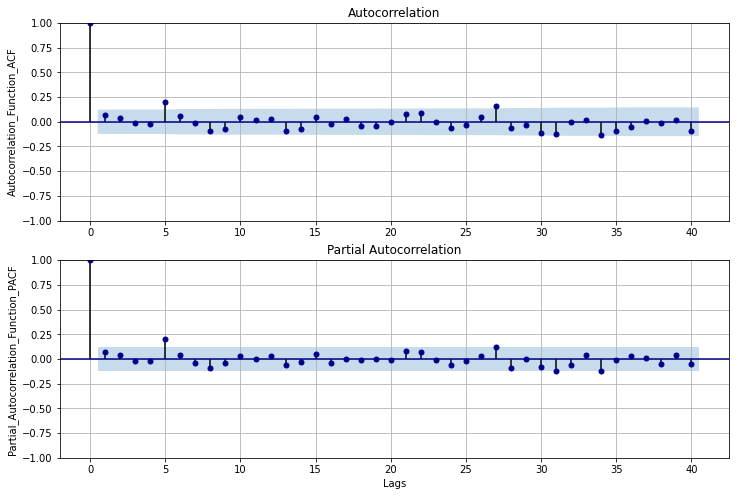



Use this plot to define the parameters (p, q) for testing ARIMA and ARMA models.

p defines the order of the autoregressive part (AR) of the time series.
p = lags correspondent to the spikes of PACF plot (2nd plot) that are outside the error (blue region).

For instance, if there are spikes in both lag = 1 and lag = 2, then p = 2, or p = 1

q defines the order of the moving average part (MA) of the time series.
q = lags correspondent to the spikes of ACF plot that are outside blue region.

For instance, if all spikes until lag = 6 are outside the blue region, then q = 1, 2, 3, 4, 5, 6.

For lag = 0, the correlation and partial correlation coefficients are always equal to 1, because the data is always perfectly correlated to itself.
Therefore, ignore the first spikes (lag = 0) from ACF and PACF plots.


In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_ANALYZE = 'usage_kwh_log'
# COLUMN_TO_ANALYZE = string (inside quotes) containing the name of the column that will be analyzed. 
# e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.

NUMBER_OF_LAGS = 40
# NUMBER_OF_LAGS = integer value. e.g. number_of_lags = 50
# represents how much lags will be tested, and the length of the horizontal axis.

X_AXIS_ROTATION = 0
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'lag_diagnosis.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.

ewf.lag_diagnosis (df = DATASET, column_to_analyze = COLUMN_TO_ANALYZE, number_of_lags = NUMBER_OF_LAGS, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

# We can see a very cyclic autocorrelation behavior.
- We can consider q = range(1, 25) - a full cycle (day);
- p = range(1,25)

### **Obtaining the 'd' parameter of ARIMA (p, q, d) model**

ADF Statistic for 1 Order Differencing
ADF Statistic: -7.863632
p-value: 0.000000
Null-hypothesis: the process is non-stationary. p-value represents this probability.
For a 0.95 confidence level, the 1 Order Difference is stationary.
You may select d = 1

ADF Statistic for 2 Order Differencing
ADF Statistic: -7.949677
p-value: 0.000000
Null-hypothesis: the process is non-stationary. p-value represents this probability.
For a 0.95 confidence level, the 2 Order Difference is stationary.
You may select d = 2



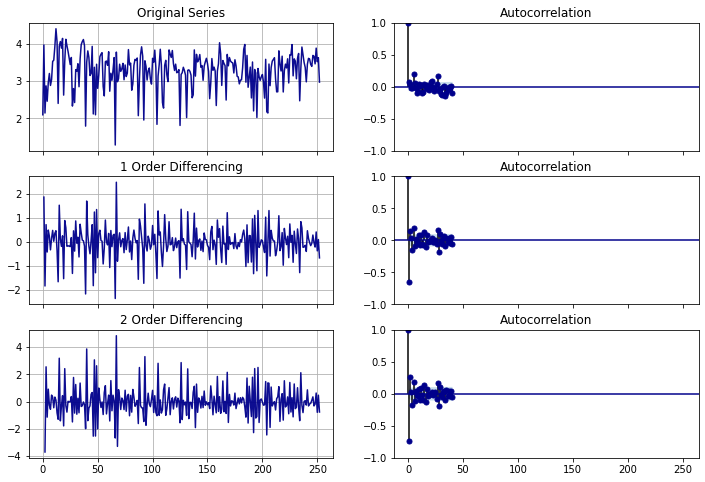



d = differentiation order for making the process stationary.

If d = N, then we have to make N successive differentiations.
A differentiation consists on substracting a signal Si from its previous signal Si-1.

Example: 1st-order differentiating consists on taking the differences on the original time series.
The 2nd-order, in turns, consists in differentiating the 1st-order differentiation series.


In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_ANALYZE = 'usage_kwh_log'
# COLUMN_TO_ANALYZE = string (inside quotes) containing the name of the column that will be analyzed. 
# e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.

NUMBER_OF_LAGS = 40
# NUMBER_OF_LAGS = integer value. e.g. number_of_lags = 50
# represents how much lags will be tested, and the length of the horizontal axis.

MAX_TESTED_d = 2
#MAX_TESTED_d: differential order (integer value)
#change the integer if you want to test other cases. By default, MAX_TESTED_d = 2, meaning
# that the values d = 0, 1, and 2 will be tested.
# If MAX_TESTED_d = 1, d = 0 and 1 will be tested.
# If MAX_TESTED_d = 3, d = 0, 1, 2, and 3 will be tested, and so on.

CONFIDENCE_LEVEL = 0.95
# CONFIDENCE_LEVEL = 0.95 = 95% confidence
# Set CONFIDENCE_LEVEL = 0.90 to get 0.90 = 90% confidence in the analysis.
# Notice that, when less trust is needed, we can reduce CONFIDENCE_LEVEL 
# to get less restrictive results.

X_AXIS_ROTATION = 0
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'test_d_parameters.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.

ewf.test_d_parameters (df = DATASET, column_to_analyze = COLUMN_TO_ANALYZE, number_of_lags = NUMBER_OF_LAGS, max_tested_d = MAX_TESTED_d, confidence_level = CONFIDENCE_LEVEL, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Obtaining the best ARIMA (p, q, d) model**

ARIMA model from date (or measurement) = 2018-01-02 06:00:00; to date (or measurement) = 2018-12-04 12:00:00.



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr

                               SARIMAX Results                                
Dep. Variable:          usage_kwh_log   No. Observations:                  253
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -188.769
Date:                Tue, 26 Jul 2022   AIC                            383.539
Time:                        22:08:18   BIC                            394.127
Sample:                             0   HQIC                           387.799
                                - 253                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0743      0.067      1.105      0.269      -0.057       0.206
ma.L1         -0.9996      0.397     -2.516      0.012      -1.778      -0.221
sigma2         0.2565      0.097      2.649      0.0

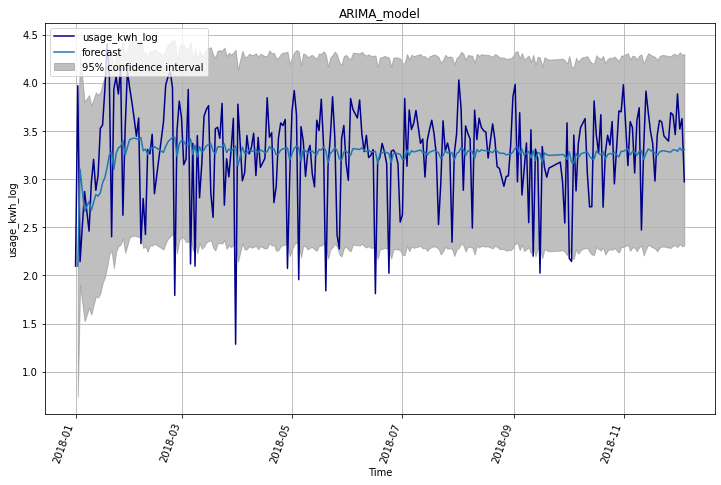



Check the dataframe containing the ARIMA predictions:



,timestamp,month,week,day,day_of_week,load_type_light_OneHotEnc,load_type_maximum_OneHotEnc,load_type_medium_OneHotEnc,lagging_current_reactive_power_kvarh_log,leading_current_reactive_power_kvarh_log,co2_tco2_log,lagging_current_power_factor_log,leading_current_power_factor_log,nsm_log,usage_kwh_log,arima_predictions,lower_cl,upper_cl
0,2018-01-01 00:00:00,1,1,1,1,1.0,0.0,0.0,1.505262,2.067875,-6.173786,4.426909,4.184504,10.498746,2.096391,0.000000,-1959.964452,1959.964452
1,2018-01-02 06:00:00,1,1,2,4,1.0,0.0,0.0,3.164469,0.034965,-3.757872,4.411671,4.587960,10.611277,3.969748,2.096390,0.742162,3.450619
2,2018-01-03 12:00:00,1,1,3,7,1.0,0.0,0.0,0.704788,2.294133,-5.837314,4.458656,4.136259,10.712416,2.143374,3.102664,1.902226,4.303101
3,2018-01-06 00:00:00,1,1,6,5,1.0,0.0,0.0,2.308062,1.325394,-4.938315,4.283139,4.466448,10.498746,2.871708,2.663443,1.524678,3.802208
4,2018-01-08 12:00:00,1,2,8,6,1.0,0.0,0.0,1.440210,1.792162,-5.521461,4.406107,4.269865,10.712416,2.459724,2.767615,1.662233,3.872997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,2018-11-29 12:00:00,11,48,29,5,1.0,0.0,0.0,2.592321,0.855620,-4.286716,4.447324,4.531214,10.712416,3.461971,3.303534,2.309009,4.298060
249,2018-11-30 18:00:00,11,48,30,5,1.0,0.0,0.0,3.031502,1.067437,-3.839702,4.451893,4.524674,10.804258,3.884955,3.288882,2.294364,4.283399
250,2018-12-02 00:00:00,12,48,2,1,1.0,0.0,0.0,2.598905,0.646056,-4.194165,4.405411,4.581671,10.498746,3.520520,3.322701,2.328191,4.317211
251,2018-12-03 06:00:00,12,49,3,1,1.0,0.0,0.0,2.698056,0.139182,-4.104395,4.386886,4.575722,10.611277,3.628194,3.296414,2.301912,4.290916




Notice that the presence of data outside the confidence interval limits of the ARIMA forecast is a strong indicative of outliers or of untrust time series.

For instance: if you observe a very sharp and sudden deviation from the predictive time series, it can be an indicative of incomplete information or outliers presence.

A famous case is the pandemic data: due to lags or latencies on the time needed for consolidating the information in some places, the data could be incomplete in a given day, leading to a sharp decrease that did not actually occurred.


REMEMBER: q represents the moving average (MA) part of the time series.
Then, it is interesting to group the time series usage_kwh_log by each q = 1 periods when modelling or analyzing it.
For that, you can use moving window or rolling functions.



In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_ANALYZE = 'usage_kwh_log'
# COLUMN_TO_ANALYZE = string (inside quotes) containing the name of the column that will be analyzed. 
# e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.

TIMESTAMP_TAG_COLUMN = 'timestamp'
# TIMESTAMP_TAG_COLUMN = None - keep it as None if you do not want to inform the timestamps
# Alternatively, declare a string (inside quotes), 
# containing the name of the column containing the time information. 
# e.g. TIMESTAMP_TAG_COLUMN = "DATE" will take the timestamps from column 'DATE'.
# If no column is provided, the index in the dataframe will be used.

p_VALS_LIST = [1,5]
#p_vals: list of integers correspondent to the lags (spikes) in the PACF plot.
# From function lag_diagnosis
# e.g. for testing the values 1, 2, and 3, set p_VALS_LIST = [1, 2, 3]
# for testing 1 and 5, set p_VALS_LIST = [1, 5]

BEST_d_PARAM = 1
#d = difference for making the process stationary.
# From function test_d_parameters
# Integer value. Alternatively, set BEST_d_PARAM as the 'd' value returned from test_d_parameters
# e.g. BEST_d_PARAM = 0, for the ARMA model;
# e.g. BEST_d_PARAM = 2; BEST_d_PARAM = 3; etc.

q_VALS_LIST = [1,5]
#q_vals: list of integers correspondent to the lags (spikes) in ACF plot.
# From function lag_diagnosis
# e.g. for testing the values 1, 2, and 3, set p_VALS_LIST = [1, 2, 3]
# for testing 1 and 5, set p_VALS_LIST = [1, 5]

## WARNING: do not test the ARIMA/ARMA model for p = 0, or q = 0.
## For lag = 0, the correlation and partial correlation coefficients 
## are always equal to 1, because the data is perfectly correlated to itself. 
## Therefore, ignore the first spikes (lag = 0) of ACF and PACF plots.

CONFIDENCE_LEVEL = 0.95
# CONFIDENCE_LEVEL = 0.95 = 95% confidence
# Set CONFIDENCE_LEVEL = 0.90 to get 0.90 = 90% confidence in the analysis.
# Notice that, when less trust is needed, we can reduce CONFIDENCE_LEVEL 
# to get less restrictive results.

X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'arima_model.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.

#ARIMA model object saved as ARIMA_model; dictionary saved as arima_summ_dict.
# Dataframe object containing model predictions and confidence intervals saved as arima_df
# Simply modify these object on the left of equality:
ARIMA_model, arima_summ_dict, arima_df = ewf.best_arima_model (df = DATASET, column_to_analyze = COLUMN_TO_ANALYZE, p_vals = p_VALS_LIST, d = BEST_d_PARAM, q_vals = q_VALS_LIST, timestamp_tag_column = TIMESTAMP_TAG_COLUMN, confidence_level = CONFIDENCE_LEVEL, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

In [ ]:
arima_summ_dict

{'AIC': 383.538913655141,
 'BIC': 394.1272009176753,
 'MAE': 0.39363574726964645,
 'd': 1,
 'log_likelihood': -188.7694568275705,
 'p': 1,
 'q': 1}

### **Decomposing seasonality and trend of the time series**

Testing additive model for seasonal decomposition.

Testing the presence of until 100 periods or cycles in the time series.

Number of total cycles or periods in time series: 2.

Seasonal decomposition concluded using (253,) observations.

Check the first 10 rows of the seasonal decompose dataframe obtained:



,timestamp,observed_data,seasonal_component,trend_component,residuals
0,2018-01-01 00:00:00,NaN,NaN,NaN,NaN
1,2018-01-02 06:00:00,NaN,NaN,NaN,NaN
2,2018-01-03 12:00:00,NaN,NaN,NaN,NaN
3,2018-01-06 00:00:00,NaN,NaN,NaN,NaN
4,2018-01-08 12:00:00,NaN,NaN,NaN,NaN
5,2018-01-09 18:00:00,NaN,NaN,NaN,NaN
6,2018-01-11 00:00:00,NaN,NaN,NaN,NaN
7,2018-01-12 06:00:00,NaN,NaN,NaN,NaN
8,2018-01-13 12:00:00,NaN,NaN,NaN,NaN
9,2018-01-14 18:00:00,NaN,NaN,NaN,NaN




Check the time series decomposition graphics for the additive model:



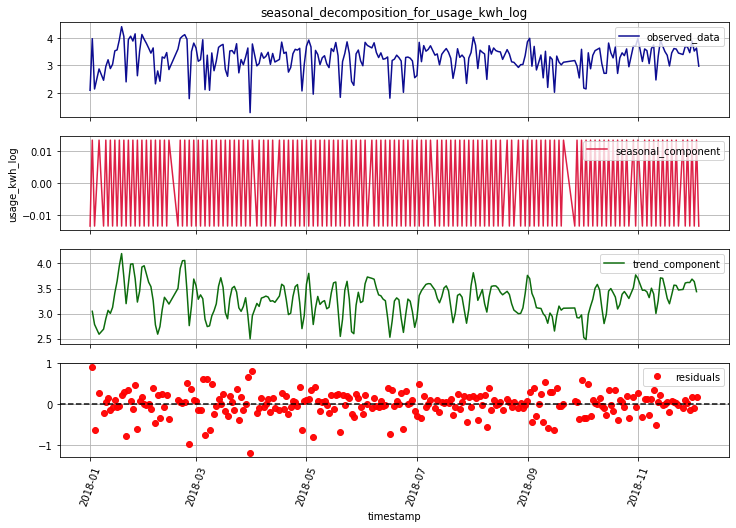

The full dataframe obtained from the decomposition was returned as seasonal_decompose_df.


In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

RESPONSE_COLUMN_TO_ANALYZE = "usage_kwh_log"
#response_column_to_analyze: string (inside quotes), 
# containing the name of the column that will be analyzed.
# e.g. response_column_to_analyze = "column1" will analyze the column named as 'column1'.
# WARNING: This must be the response variable
COLUMN_WITH_TIMESTAMPS = "timestamp"
#column_with_timestamps: string (inside quotes), 
# containing the name of the column containing timestamps.
# Keep it as None if you want to set the index as the time.
# e.g. response_column_to_analyze = "column1" will analyze the column named as 'column1'.

DECOMPOSITION_MODE = "additive"
# decomposition_mode = "additive" - manipulate the parameter 'model' 
# from seasonal_decompose.
# model = decomposition_mode
# Alternatively, set decomposition_mode = "multiplicative" 
# for decomposing as a multiplicative time series.
MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = 100
# MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = integer (minimum value is 2) representing
# the total of cycles or periods that may be present on time series. The function will loop through
# 2 to MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST to find the number that minimizes the sum of
# modules (absolute values) of the residues.
# e.g. MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = 4 will test 2, 3 and 4 cycles on the time series.

X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'seasonal_decomposition.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.

# Dataframe object containing the series resultant from the decomposition (seasonality and trend)
# returned as seasonal_decompose_df.
# Simply modify these objects on the left of equality:
seasonal_decompose_df = ewf.seasonal_decomposition (df = DATASET, response_column_to_analyze = RESPONSE_COLUMN_TO_ANALYZE, column_with_timestamps = COLUMN_WITH_TIMESTAMPS, decomposition_mode = DECOMPOSITION_MODE, maximum_number_of_cycles_or_periods_to_test = MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

Testing additive model for seasonal decomposition.

Testing the presence of until 100 periods or cycles in the time series.

Number of total cycles or periods in time series: 2.

Seasonal decomposition concluded using (253,) observations.

Check the first 10 rows of the seasonal decompose dataframe obtained:



,timestamp,observed_data,seasonal_component,trend_component,residuals
0,0,2.096391,-0.013318,NaN,NaN
1,1,3.969748,0.013318,3.044815,0.911615
2,2,2.143374,-0.013318,2.782051,-0.625359
3,3,2.871708,0.013318,2.586629,0.271762
4,4,2.459724,-0.013318,2.688259,-0.215217
5,5,2.961878,0.013318,2.897058,0.051503
6,6,3.204750,-0.013318,3.063755,0.154313
7,7,2.883641,0.013318,3.002981,-0.132658
8,8,3.039893,-0.013318,3.122741,-0.069530
9,9,3.527536,0.013318,3.414336,0.099883




Check the time series decomposition graphics for the additive model:



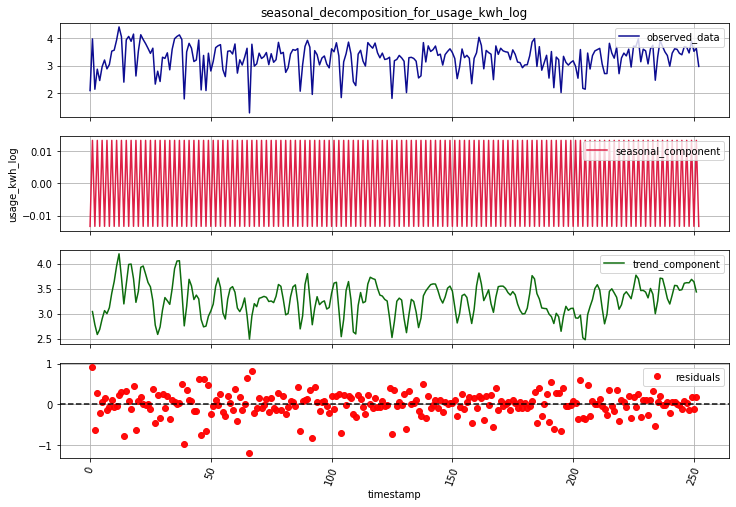

The full dataframe obtained from the decomposition was returned as seasonal_decompose_df.


In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

RESPONSE_COLUMN_TO_ANALYZE = "usage_kwh_log"
#response_column_to_analyze: string (inside quotes), 
# containing the name of the column that will be analyzed.
# e.g. response_column_to_analyze = "column1" will analyze the column named as 'column1'.
# WARNING: This must be the response variable
COLUMN_WITH_TIMESTAMPS = None
#column_with_timestamps: string (inside quotes), 
# containing the name of the column containing timestamps.
# Keep it as None if you want to set the index as the time.
# e.g. response_column_to_analyze = "column1" will analyze the column named as 'column1'.

DECOMPOSITION_MODE = "additive"
# decomposition_mode = "additive" - manipulate the parameter 'model' 
# from seasonal_decompose.
# model = decomposition_mode
# Alternatively, set decomposition_mode = "multiplicative" 
# for decomposing as a multiplicative time series.
MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = 100
# MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = integer (minimum value is 2) representing
# the total of cycles or periods that may be present on time series. The function will loop through
# 2 to MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST to find the number that minimizes the sum of
# modules (absolute values) of the residues.
# e.g. MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = 4 will test 2, 3 and 4 cycles on the time series.

X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'seasonal_decomposition.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.

# Dataframe object containing the series resultant from the decomposition (seasonality and trend)
# returned as seasonal_decompose_df.
# Simply modify these objects on the left of equality:
seasonal_decompose_df = ewf.seasonal_decomposition (df = DATASET, response_column_to_analyze = RESPONSE_COLUMN_TO_ANALYZE, column_with_timestamps = COLUMN_WITH_TIMESTAMPS, decomposition_mode = DECOMPOSITION_MODE, maximum_number_of_cycles_or_periods_to_test = MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

Testing multiplicative model for seasonal decomposition.

Testing the presence of until 100 periods or cycles in the time series.

Number of total cycles or periods in time series: 2.

Seasonal decomposition concluded using (253,) observations.

Check the first 10 rows of the seasonal decompose dataframe obtained:



,timestamp,observed_data,seasonal_component,trend_component,residuals
0,0,2.096391,0.994844,NaN,NaN
1,1,3.969748,1.005156,3.044815,1.297085
2,2,2.143374,0.994844,2.782051,0.774423
3,3,2.871708,1.005156,2.586629,1.104518
4,4,2.459724,0.994844,2.688259,0.919730
5,5,2.961878,1.005156,2.897058,1.017130
6,6,3.204750,0.994844,3.063755,1.051442
7,7,2.883641,1.005156,3.002981,0.955333
8,8,3.039893,0.994844,3.122741,0.978515
9,9,3.527536,1.005156,3.414336,1.027855




Check the time series decomposition graphics for the multiplicative model:



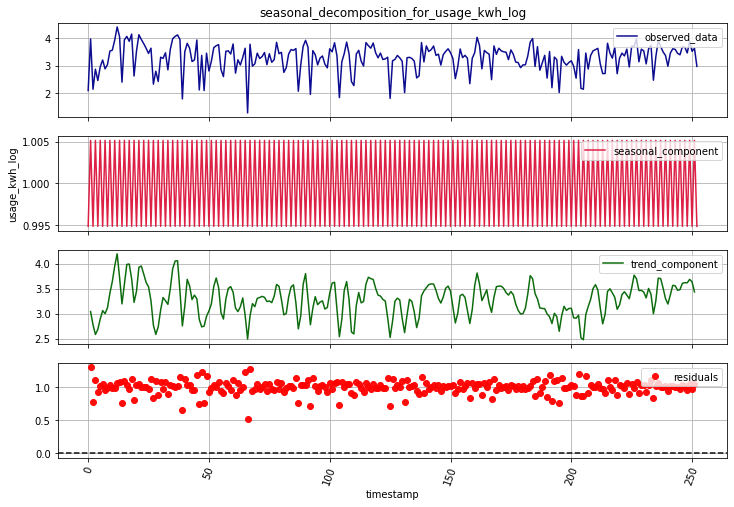

The full dataframe obtained from the decomposition was returned as seasonal_decompose_df.


In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

RESPONSE_COLUMN_TO_ANALYZE = "usage_kwh_log"
#response_column_to_analyze: string (inside quotes), 
# containing the name of the column that will be analyzed.
# e.g. response_column_to_analyze = "column1" will analyze the column named as 'column1'.
# WARNING: This must be the response variable
COLUMN_WITH_TIMESTAMPS = None
#column_with_timestamps: string (inside quotes), 
# containing the name of the column containing timestamps.
# Keep it as None if you want to set the index as the time.
# e.g. response_column_to_analyze = "column1" will analyze the column named as 'column1'.

DECOMPOSITION_MODE = "multiplicative"
# decomposition_mode = "additive" - manipulate the parameter 'model' 
# from seasonal_decompose.
# model = decomposition_mode
# Alternatively, set decomposition_mode = "multiplicative" 
# for decomposing as a multiplicative time series.
MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = 100
# MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = integer (minimum value is 2) representing
# the total of cycles or periods that may be present on time series. The function will loop through
# 2 to MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST to find the number that minimizes the sum of
# modules (absolute values) of the residues.
# e.g. MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = 4 will test 2, 3 and 4 cycles on the time series.

X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'seasonal_decomposition.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.

# Dataframe object containing the series resultant from the decomposition (seasonality and trend)
# returned as seasonal_decompose_df.
# Simply modify these objects on the left of equality:
seasonal_decompose_df = ewf.seasonal_decomposition (df = DATASET, response_column_to_analyze = RESPONSE_COLUMN_TO_ANALYZE, column_with_timestamps = COLUMN_WITH_TIMESTAMPS, decomposition_mode = DECOMPOSITION_MODE, maximum_number_of_cycles_or_periods_to_test = MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

# The high frequency indicates no clear seasonal component

### **Importing or exporting models and dictionaries (or lists)**

#### Case 4: export a model and/or a dictionary (or a list)

In [ ]:
ACTION = 'export'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = 'arima_model_30h'
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'arima'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_lambda' for deep learning tensorflow models containing 
# lambda layers. Such models are compressed as tar.gz.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = ARIMA_model
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = True
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

idsw.import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

The files will be downloaded to your computer.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ARIMA model: arima_model_30h.pkl successfully downloaded from Colab environment.
Export of files completed.


## **Exporting the dataframe as CSV file (to notebook's workspace)**

In [ ]:
## WARNING: all files exported from this function are .csv (comma separated values)

DATAFRAME_OBJ_TO_BE_EXPORTED = dataset
# Alternatively: object containing the dataset to be exported.
# DATAFRAME_OBJ_TO_BE_EXPORTED: dataframe object that is going to be exported from the
# function. Since it is an object (not a string), it should not be declared in quotes.
# example: DATAFRAME_OBJ_TO_BE_EXPORTED = dataset will export the dataset object.
# ATTENTION: The dataframe object must be a Pandas dataframe.

FILE_DIRECTORY_PATH = ""
# FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "" 
# or FILE_DIRECTORY_PATH = "folder"
# If you want to export the file to AWS S3, this parameter will have no effect.
# In this case, you can set FILE_DIRECTORY_PATH = None

NEW_FILE_NAME_WITHOUT_EXTENSION = "dataset"
# NEW_FILE_NAME_WITHOUT_EXTENSION - (string, in quotes): input the name of the 
# file without the extension. e.g. set NEW_FILE_NAME_WITHOUT_EXTENSION = "my_file" 
# to export the CSV file 'my_file.csv' to notebook's workspace.

idsw.export_pd_dataframe_as_csv (dataframe_obj_to_be_exported = DATAFRAME_OBJ_TO_BE_EXPORTED, new_file_name_without_extension = NEW_FILE_NAME_WITHOUT_EXTENSION, file_directory_path = FILE_DIRECTORY_PATH)

## **Downloading a file from Google Colab to the local machine; or uploading a file from the machine to Colab's instant memory**

#### Case 1: upload a file to Colab's workspace

In [ ]:
ACTION = 'upload'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

FILE_TO_DOWNLOAD_FROM_COLAB = None
# FILE_TO_DOWNLOAD_FROM_COLAB = None. This parameter is obbligatory when
# action = 'download'. 
# Declare as FILE_TO_DOWNLOAD_FROM_COLAB the file that you want to download, with
# the correspondent extension.
# It should not be declared in quotes.
# e.g. to download a dictionary named dict, FILE_TO_DOWNLOAD_FROM_COLAB = 'dict.pkl'
# To download a dataframe named df, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'df.csv'
# To export a model named keras_model, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'keras_model.h5'

# Dictionary storing the uploaded files returned as colab_files_dict.
# Simply modify this object on the left of the equality:
colab_files_dict = idsw.upload_to_or_download_file_from_colab (action = ACTION, file_to_download_from_colab = FILE_TO_DOWNLOAD_FROM_COLAB)

#### Case 2: download a file from Colab's workspace

In [ ]:
ACTION = 'download'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

FILE_TO_DOWNLOAD_FROM_COLAB = None
# FILE_TO_DOWNLOAD_FROM_COLAB = None. This parameter is obbligatory when
# action = 'download'. 
# Declare as FILE_TO_DOWNLOAD_FROM_COLAB the file that you want to download, with
# the correspondent extension.
# It should not be declared in quotes.
# e.g. to download a dictionary named dict, FILE_TO_DOWNLOAD_FROM_COLAB = 'dict.pkl'
# To download a dataframe named df, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'df.csv'
# To export a model nameACTION = 'upload'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

idsw.upload_to_or_download_file_from_colab (action = ACTION, file_to_download_from_colab = FILE_TO_DOWNLOAD_FROM_COLAB)

## **Exporting a list of files from notebook's workspace to AWS Simple Storage Service (S3)**

In [ ]:
LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['s3_file1.txt', 's3_file2.txt']
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS: list containing all the files to export to S3.
# Declare it as a list even if only a single file will be exported.
# It must be a list of strings containing the file names followed by the extensions.
# Example, to a export a single file my_file.ext, where my_file is the name and ext is the
# extension:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['my_file.ext']
# To export 3 files, file1.ext1, file2.ext2, and file3.ext3:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['file1.ext1', 'file2.ext2', 'file3.ext3']
# Other examples:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['Screen_Shot.png', 'dataset.csv']
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ["dictionary.pkl", "model.h5"]
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['doc.pdf', 'model.dill']

DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = ''
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT: directory from notebook's workspace
# from which the files will be exported to S3. Keep it None, or
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = "/"; or
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = '' (empty string) to export from
# the root (main) directory.
# Alternatively, set as a string containing only the directories and folders, not the file names.
# Examples: DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = 'folder1';
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = 'folder1/folder2/'
    
# For this function, all exported files must be located in the same directory.

S3_BUCKET_NAME = 'my_bucket'
## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
# with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
# "aws-bucket-1"

S3_OBJECT_FOLDER_PREFIX = ""
# S3_OBJECT_FOLDER_PREFIX = None. Keep it None; or as an empty string 
# (S3_OBJECT_FOLDER_PREFIX = ''); or as the root "/" to import the 
# whole bucket content, instead of a single object from it.
# Alternatively, set it as a string containing the subfolder from the bucket to import:
# Suppose that your bucket (admin-created) has four objects with the following object 
# keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
# s3-dg.pdf. 
# The s3-dg.pdf key does not have a prefix, so its object appears directly 
# at the root level of the bucket. If you open the Development/ folder, you see 
# the Projects.xlsx object in it.
# In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
# where 'bucket' is the bucket's name, prefix = 'my_path/.../', without the
# 'file.csv' (file name with extension) last part.

# So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
# a given folder (directory) of the bucket.
# DO NOT PUT A SLASH before (to the right of) the prefix;
# DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

# Alternatively, provide the full path of a given file if you want to import only it:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
# where my_file is the file's name, and ext is its extension.


# Attention: after running this function for connecting with AWS Simple Storage System (S3), 
# your 'AWS Access key ID' and your 'Secret access key' will be requested.
# The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
# other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
# and the prefix. All of these are sensitive information from the organization.
# Therefore, after importing the information, always remember of cleaning the output of this cell
# and of removing such information from the strings.
# Remember that these data may contain privilege for accessing protected information, 
# so it should not be used for non-authorized people.

# Also, remember of deleting the imported files from the workspace after finishing the analysis.
# The costs for storing the files in S3 is quite inferior than those for storing directly in the
# workspace. Also, files stored in S3 may be accessed for other users than those with access to
# the notebook's workspace.
idsw.export_files_to_s3 (list_of_file_names_with_extensions = LIST_OF_FILE_NAMES_WITH_EXTENSIONS, directory_of_notebook_workspace_storing_files_to_export = DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT, s3_bucket_name = S3_BUCKET_NAME, s3_obj_prefix = S3_OBJECT_FOLDER_PREFIX)

****